In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

## 8.1 LSTM으로 텍스트 생성하기

### 8.1.2 시퀀스 데이터를 어떻게 생성할까?


- 딥러닝에서 시퀀스 데이터를 생성하는 일반적인 방법은 이전 토큰을 입력으로 사용해서 시퀀스의 다음 1개 또는 몇 개의 토큰을 RNN이나 ConvNet으로 예측하는 것이다.

    - 예를들어 "the cat is on ma"란 입력이 주어지면 다음 글자인 타깃 "t"를 예측하도록 네트워크를 훈련한다.
    

- 텍스트 데이터를 다룰 때 토큰은 보통 단어 또는 글자이다.

- 이전 토큰들이 주어졌을 때 다음 토큰의 확률을 모델링할 수 있는 네트워크를 **언어 모델**(language model)이라고 한다.

    - 언어 모델을 언어의 통계적 구조인 잠재공간(latent space)을 탐색한다.
    
    
- 언어 모델을 훈련하고 나면 이 모델에서 샘플링 할 수 있으며, 이를 통해 새로운 시퀀스를 생성한다.
    
    1. 초기 텍스트 문자열(**조건 데이터**(conditioning data))을 주입하고 새로운 글자나 단어를 생성한다. 
    2. 생성된 출력은 다시 입력 데이터로 추가된다.
    3. `1~2`과정을 여러번 반복한다.
    
    
![](./images/text-gen.png)

### 8.1.3 샘플링 전략의 중요성

- 텍스트를 생성할 때 다음 글자를 선택하는 방법이 중요하다.


- 단순한 방법은 가장 높은 확률을 가진 글자를 선택하는 **탐욕적 샘플링**(greedy sampling)이다. 
    - 이 방법은 반복적이고 예상 가능한 문자열을 마들기 때문에 논리적인 언어처럼 보이지 않는다.
    
   
- 다음 글자의 확률 분포에서 샘플링하는 과정에 무작위성을 추가하는 방법이 있는데, 이를 **확률적 샘플링**(stochastic sampling)이라고 부른다. 
    - 예를들어, `'e'`가 다음 글자가 될 확률이 `0.3`이라면, 모델이 `30%`정도는 이 글자를 선택한다.
    
    
- 모델의 소프트맥스(softmax) 출력은 확률적 샘플링에 사용하기 좋다.
    - 이따금 샘플링될 것 같지 않은 글자를 샘플링한다.
    - 훈련 데이터에는 없지만 실제 같은 새로운 단어를 만들어 문장을 생성한다.
    - 한가지 문제는, 샘플링 과정에서 무작위성의 양을 조절할 방법이 없는 것이다.
    
   
- 생성 모델에서 샘플링을 할 때 생성 과정에서 무작위성의 양을 바꾸어 시도해 보는 것이 좋다.


- 샘플링 과정에서 확률의 양을 조절하기 위해 **소프트맥스 온도**(softmax temperature)라는 파라미터를 사용한다.
    - 이 파라미터는 샘플링에 사용되는 확률 분포의 엔트로피를 나타낸다. 
    - `temperature` 값이 주어지면 가중치를 적용하여 모델의 소프트맥스 출력인 원본 확률 분포에서 새로운 확률 분포를 계산한다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

dist = np.random.randint(1, 10, size=100)

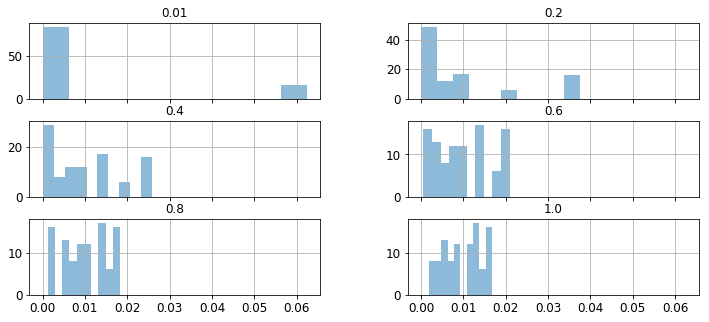

In [3]:
import pandas as pd

plt_dist = (
    reweight_distribution(dist, temperature=0.01),
    reweight_distribution(dist, temperature=0.2),
    reweight_distribution(dist, temperature=0.4),
    reweight_distribution(dist, temperature=0.6),
    reweight_distribution(dist, temperature=0.8),
    reweight_distribution(dist, temperature=1.0)
)

plt_dist = np.column_stack(plt_dist)

df = pd.DataFrame(plt_dist, 
                  columns=['0.01', '0.2', '0.4','0.6', '0.8', '1.0'])

df.hist(alpha=0.5, bins=10, figsize=(12, 5), sharex=True);

---

### 8.1.4 글자 수준의 LSTM 텍스트 생성 모델 구현

이런 아이디어를 케라스로 구현해 보죠. 먼저 언어 모델을 학습하기 위해 많은 텍스트 데이터가 필요합니다. 위키피디아나 반지의 제왕처럼 아주 큰 텍스트 파일이나 텍스트 파일의 묶음을 사용할 수 있습니다. 

이 예에서는 19세기 후반 독일의 철학자 니체의 글을 사용하겠습니다(영어로 번역된 글입니다). 학습할 언어 모델은 일반적인 영어 모델이 아니라 니체의 문체와 특정 주제를 따르는 모델일 것입니다.

#### 데이터 전처리

먼저 말뭉치를 다운로드하고 소문자로 바꿉니다:

In [4]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt'
)

text = open(path).read().lower()
print('말뭉치 크기:', len(text))

말뭉치 크기: 600893


In [5]:
type(text)

str

In [6]:
text[:5]

'prefa'

그 다음 `maxlen` 길이를 가진 시퀀스를 중복하여 추출합니다. 추출된 시퀀스를 원-핫 인코딩으로 변환하고 크기가 `(sequences, maxlen, unique_characters)`인 3D 넘파이 배열 `x`로 합칩니다. 동시에 훈련 샘플에 상응하는 타깃을 담은 배열 y를 준비합니다. 타깃은 추출된 시퀀스 다음에 오는 원-핫 인코딩된 글자입니다.

In [7]:
# 60개 글자로 된 시퀀스를 추출한다.
maxlen = 60

# 세 글자씩 건너 뛰면서 새로운 시퀀스를 샘플링한다.
step = 3

# 추출한 시퀀스를 담을 리스트
sentences = []

# 타깃(시퀀스 다음 글자)을 담을 리스트
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i+maxlen])
    next_chars.append(text[i + maxlen])
print('시퀀스 개수:', len(sentences))
print('sentences[0]\n', sentences[0])
print('='*50)
print('text[:60]\n', text[:60])

시퀀스 개수: 200278
sentences[0]
 preface


supposing that truth is a woman--what then? is the
text[:60]
 preface


supposing that truth is a woman--what then? is the


In [8]:
# 말뭉치에서 고유한 글자를 담은 리스트
chars = sorted(list(set(text)))
print('고유한 글자:', len(chars))
print(chars[:10])
# chars 리스트에 있는 글자와 글자의 인덱스를 매핑한 딕셔너리
# char_indices = dict((char, chars.index(char)) for char in chars)
char_indices = {char: idx for idx, char in enumerate(chars)}

고유한 글자: 57
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.']


In [9]:
# 글자를 원-핫 인코딩하여 0과 1의 이진 배열로 바꾼다.
print('벡터화...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentences in enumerate(sentences):
    for t, char in enumerate(sentences):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print('x.shape :', x.shape)
print('y.shape :', y.shape)

벡터화...
x.shape : (200278, 60, 57)
y.shape : (200278, 57)


#### 네트워크 구성

이 네트워크는 하나의 LSTM 층과 그 뒤에 Dense 분류기가 뒤따릅니다. 분류기는 가능한 모든 글자에 대한 소프트맥스 출력을 만듭니다. 순환 신경망이 시퀀스 데이터를 생성하는 유일한 방법은 아닙니다. 

최근에는 1D 컨브넷도 이런 작업에 아주 잘 들어 맞는다는 것이 밝혀졌습니다.

In [10]:
from keras import layers, models

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))


타깃이 원-핫 인코딩되어 있기 때문에 모델을 훈련하기 위해 categorical_crossentropy 손실을 사용합니다:

In [11]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#### 언어 모델 훈련과 샘플링

훈련된 모델과 시드로 쓰일 간단한 텍스트가 주어지면 다음과 같이 반복하여 새로운 텍스트를 생성할 수 있습니다.


1. 지금까지 생성된 텍스트를 주입하여 모델에서 다음 글자에 대한 확률 분포를 뽑습니다.
2. 특정 온도로 이 확률 분포의 가중치를 조정합니다.
3. 가중치가 조정된 분포에서 무작위로 새로운 글자를 샘플링합니다.
4. 새로운 글자를 생성된 텍스트의 끝에 추가합니다.


다음 코드는 모델에서 나온 원본 확률 분포의 가중치를 조정하고 새로운 글자의 인덱스를 추출합니다(샘플링 함수입니다):

In [12]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

마지막으로 다음 반복문은 반복적으로 훈련하고 텍스트를 생성합니다. 에포크마다 학습이 끝난 후 여러가지 온도를 사용해 텍스트를 생성합니다. 이렇게 하면 모델이 수렴하면서 생성된 텍스트가 어떻게 진화하는지 볼 수 있습니다. 온도가 샘플링 전략에 미치는 영향도 보여 줍니다.

In [38]:
import random
import sys

random.seed(42)
start_index = random.randint(0, len(text) - maxlen - 1)

# 5 epoch 동안 모델을 훈련한다.
for epoch in range(1, 5):
    print('에포크 :', epoch)
    # 데이터에서 한 번만 반복해서 모델을 학습한다.
    model.fit(x, y, batch_size=128, epochs=1)
    
    # 무작위로 시드 텍스트를 선택한다
    seed_text = text[start_index: start_index + maxlen]
    print('--- 시드 텍스트:"' + seed_text + '"')
    
    # 여러가지 샘플링 온도를 시도한다.
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        # 시드 텍스트에서 시작해서 400개의 글자를 생성한다.
        for i in range(400):
            # 지금까지 생성된 글자를 원-핫 인코딩으로 바꾼다.
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            # 다음 글자를 샘플링 한다.
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

에포크 : 1
Epoch 1/1
200278/200278 [==============================] - 61s 302us/step - loss: 1.6068
--- 시드 텍스트:"the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the science of the spirit in the sensitions of the sense of the sense the sense of the strength the sentiment to the sensitions of the self-contries to the belare the contrary the sense and the sense of the sense of the sense of the sense of the sension of the sense of the sense the sense of the sense of the explainty the sense of the sense of the sense of the against the sense and the sense of 
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the seedly the sense his explainted the explantial sense in the fellowment of the very precised to the seamed the intential creations such a conscience and does the came into an it
it is indeed his all the seems and lough the enory and for his development the contemplate is a

#### 결과확인

- 위의 결과에서도 확인할 수 있듯이 낮은 온도(`temperature`)는 아주 반복적이고 예상되는 텍스트를 만든다.
    - 하지만 국부적인 구조는 실제와 매우 같다. 
    - 특히 모든 단어들이 실제 영단어다.
    
    
- 높은 온도에서 생성된 텍스트는 창의적인 텍스트들이 생성된다.
    - 실제 단어가 아닌 실제 단어와 비슷하게 보이는 단어들을 생성해낸다.

### 8.1.5 정리

- 이전의 토큰이 주어지면 다음 토큰(들)을 예측하는 모델을 훈련하여 시퀀스 데이터를 생성할 수 있다.

- 텍스트의 경우 이런 모델을 **언어 모델**이라고 부른다. 

- 다음 토큰을 샘플링할 때 모델이 만든 출력에 집중하는 것과 무작위성을 주입하는 것 사이에 균형을 맞추어야 한다.

- 이를 위해 **소프트맥스 온도** 개념을 사용한다. 항상 다양한 온도를 실험해서 적절한 값을 찾아야 한다. 